# **Preparation**

Connecting to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Connecting to Kaggle

In [ ]:
!mkdir ~/.kaggle

!pip install kaggle

# copying api file
!cp drive/MyDrive/kaggle.json ~/.kaggle/
# modding permission
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading Garbage Classification Image Dataset from Kaggle

In [ ]:
# downloading data using api command from the site
!kaggle datasets download -d mostafaabla/garbage-classification
# unzip the downloaded file
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

Installing Libraries

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import random
import os
from pathlib import Path
import cv2
import splitfolders
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2S

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D

          class  count
0       plastic    865
1   white-glass    775
2         trash    697
3     cardboard    891
4   green-glass    629
5         shoes   1977
6    biological    985
7       battery    945
8         paper   1050
9       clothes   5325
10        metal    769
11  brown-glass    607


<Axes: xlabel='class', ylabel='count'>

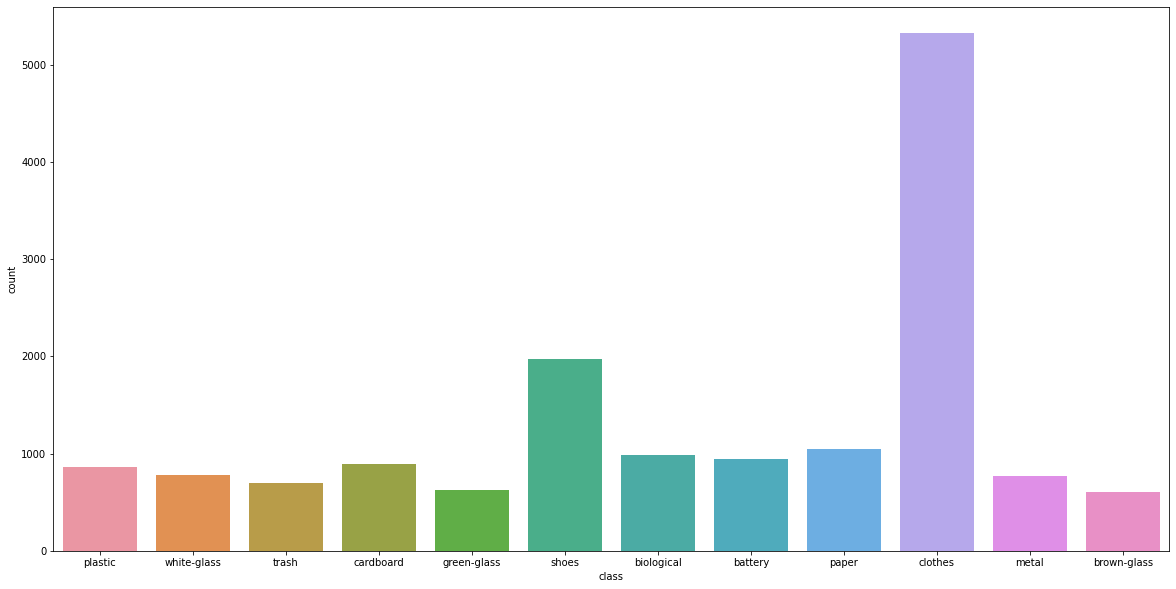

In [ ]:
img_data = {}

for folder in os.listdir("garbage_classification/"):
    img_data[folder] = len(os.listdir("garbage_classification/"+folder))

image_data = pd.DataFrame(list(img_data.items()), index=range(0,len(img_data)), columns=['class','count'])

print(image_data)

plt.figure(figsize=(20,10))
sns.barplot(x='class',y='count',data=image_data)

          class  count
0       plastic    865
1   white-glass    775
2         trash    697
3     cardboard    891
4   green-glass    629
5         shoes    977
6    biological    985
7       battery    945
8         paper   1050
9       clothes   1025
10        metal    769
11  brown-glass    607


<Axes: xlabel='class', ylabel='count'>

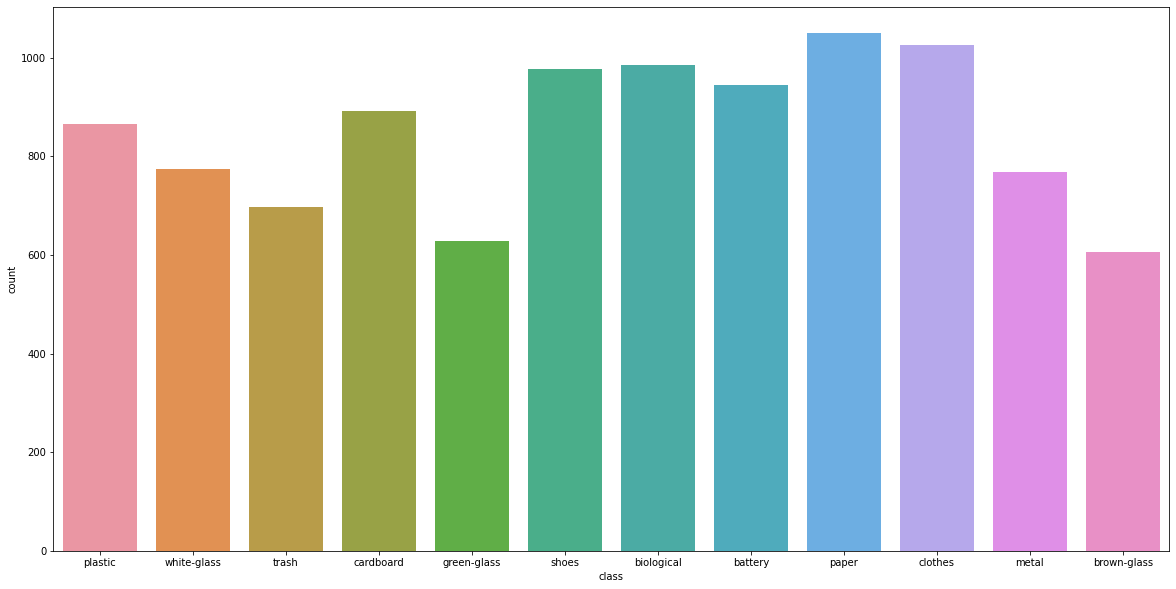

In [ ]:
# Karena terdapat kelebihan data signifikan pada class 'clothes' dan 'shoes', maka sebelum splitting, data akan diberlakukan random undersampling

# delete 4300 gambar random dari class 'clothes'

path = r'garbage_classification/clothes/'
n = 4300
img_names = os.listdir(path)  
img_names = random.sample(img_names, n)
for image in img_names:
  f = os.path.join(path, image)
  os.remove(f)

# delete 1000 gambar random dari class 'clothes'

path = r'garbage_classification/shoes/'
n = 1000
img_names = os.listdir(path)  
img_names = random.sample(img_names, n)
for image in img_names:
  f = os.path.join(path, image)
  os.remove(f)

img_data = {}

for folder in os.listdir("garbage_classification/"):
    img_data[folder] = len(os.listdir("garbage_classification/"+folder))

image_data = pd.DataFrame(list(img_data.items()), index=range(0,len(img_data)), columns=['class','count'])

print(image_data)

plt.figure(figsize=(20,10))
sns.barplot(x='class',y='count',data=image_data)

Splitting Dataset into Train, Test, and Validation Folders

In [ ]:
splitfolders.ratio("garbage_classification", output="data", seed="4761", ratio=(0.7,0.1,0.2))

Copying files: 10215 files [00:01, 7287.23 files/s]


In [ ]:
# import shutil
# shutil.rmtree("data")

Number of images in the train set : 7144 images
Number of images in the test set : 2056 images
Number of images in the val set : 1015 images

          class  count
0       plastic    605
1   white-glass    542
2         trash    487
3     cardboard    623
4   green-glass    440
5         shoes    683
6    biological    689
7       battery    661
8         paper    735
9       clothes    717
10        metal    538
11  brown-glass    424

          class  count
0       plastic    174
1   white-glass    156
2         trash    141
3     cardboard    179
4   green-glass    127
5         shoes    197
6    biological    198
7       battery    190
8         paper    210
9       clothes    206
10        metal    155
11  brown-glass    123



<Axes: xlabel='class', ylabel='count'>

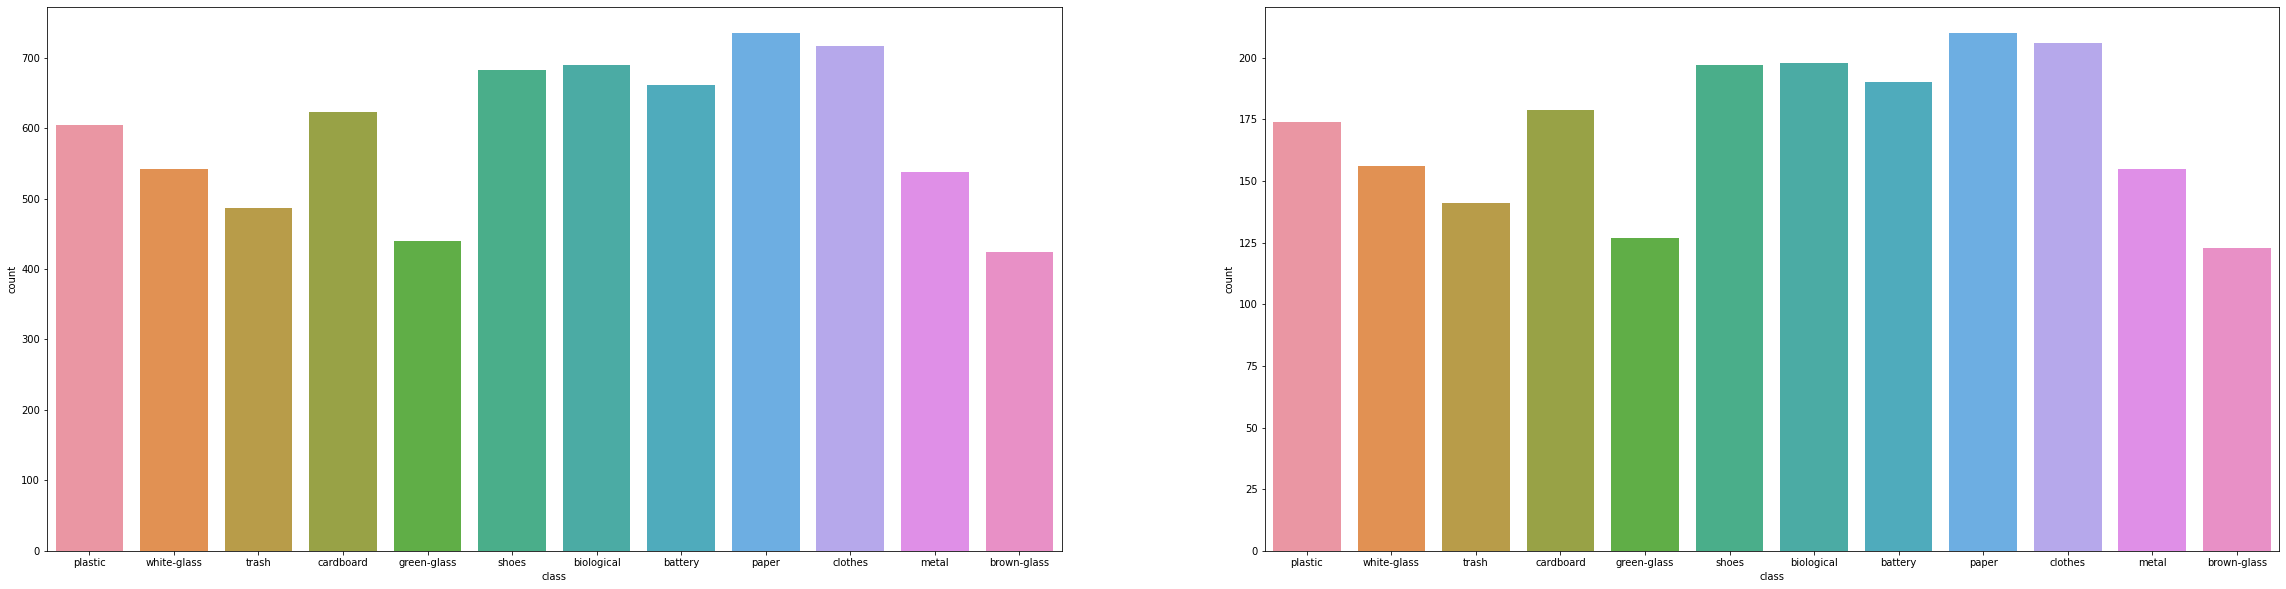

In [ ]:
data_folders = os.listdir("data")

for folder in data_folders:
  path = Path('data/' + folder)
  number_of_files = sum(1 for x in path.glob('**/*') if x.is_file())
  print(f"Number of images in the {folder} set : {number_of_files} images")

train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

quantity_tr = {}
quantity_te = {}

for folder in os.listdir(train_dir):
    quantity_tr[folder] = len(os.listdir(train_dir+folder))

for folder in os.listdir(test_dir):
    quantity_te[folder] = len(os.listdir(test_dir+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

print()

print(quantity_train)
print()
print(quantity_test)
print()

figure, ax = plt.subplots(1,2,figsize=(40,10))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history):
    color = sns.color_palette()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    

    epochs = range(len(acc))

    sns.lineplot(acc)
    sns.lineplot(val_acc)
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(loss)
    sns.lineplot(val_loss)
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history)
    plot_loss_from_history(history)

In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(val_dir)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(val_dir)):
        image_ids = os.listdir(os.path.join(val_dir,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(val_dir,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                display_resized = cv2.resize(display,(224,224))
                display_normalized = display_resized/255
                predicted_classname = inv_map_classes[np.argmax(efficientnetv2s_best_model.predict(np.array([display_normalized])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

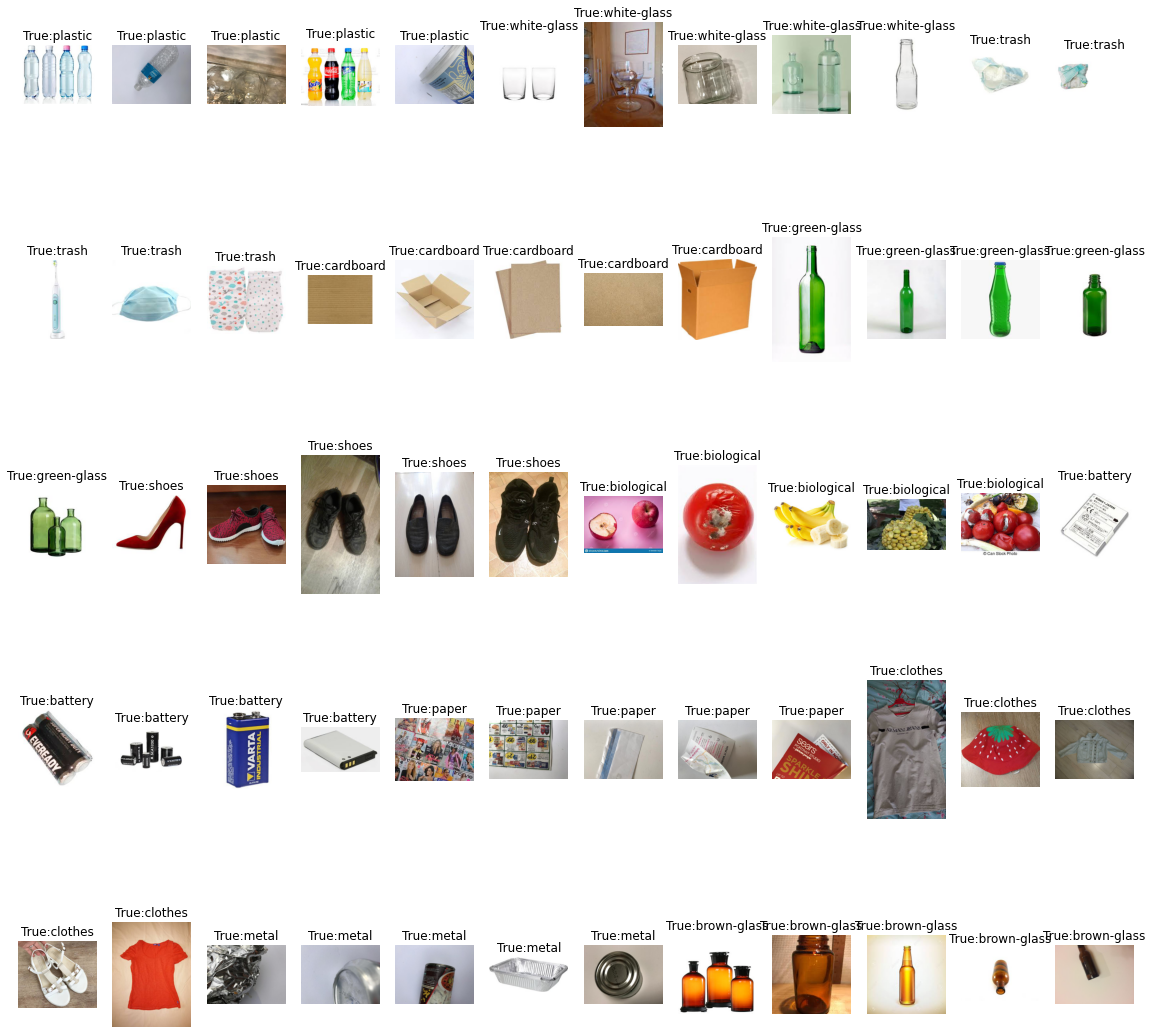

In [ ]:
show_few_images(5)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_dir, shuffle=True, batch_size=1, class_mode='categorical', target_size=(224, 224))

Found 7144 images belonging to 12 classes.
Found 2056 images belonging to 12 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}
{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
tf.keras.backend.clear_session()

# epoch config
efficientnetv2s_epoch = 30

82420632/82420632 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 24  96          ['stem_conv[0][0]']              
                             

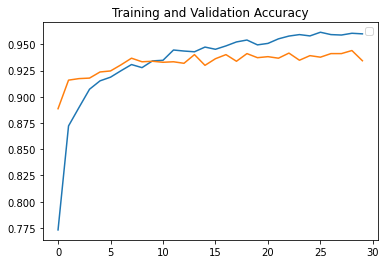

<Figure size 432x288 with 0 Axes>

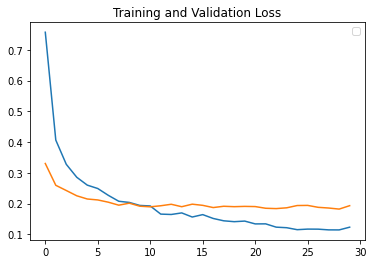

<Figure size 432x288 with 0 Axes>

In [ ]:
efficientnetv2s_model = EfficientNetV2S(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3), include_preprocessing=False)
for layers in efficientnetv2s_model.layers:
  layers.trainable=False

last_output = efficientnetv2s_model.layers[-1].output
efficientnetv2s_x = Flatten()(last_output)
efficientnetv2s_x = Dense(128, activation = 'relu')(efficientnetv2s_x)
efficientnetv2s_x = Dropout(0.5)(efficientnetv2s_x)
efficientnetv2s_x = Dense(12, activation = 'softmax')(efficientnetv2s_x)
efficientnetv2s_final_model = Model(efficientnetv2s_model.input, efficientnetv2s_x)
efficientnetv2s_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

efficientnetv2s_final_model.summary()

# efficientnetv2s
number_of_epochs = efficientnetv2s_epoch
efficientnetv2s_filepath = 'efficientnetv2s_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
efficientnetv2s_checkpoint = tf.keras.callbacks.ModelCheckpoint(efficientnetv2s_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
efficientnetv2s_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
efficientnetv2s_history = efficientnetv2s_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator, callbacks=[efficientnetv2s_checkpoint,efficientnetv2s_early_stopping],verbose=1)

do_history_stuff(efficientnetv2s_history, 'efficientnetv2s_model')

In [24]:
efficientnetv2s_best_model = efficientnetv2s_final_model

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
efficientnetv2s_pred = []

for folder in os.listdir(val_dir):
    
    test_image_ids = os.listdir(os.path.join(val_dir,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(val_dir,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255

        efficientnetv2s_image_prediction = np.argmax(efficientnetv2s_best_model.predict(np.array([img_normalized])))
        efficientnetv2s_pred.append(efficientnetv2s_image_prediction)

        image_prediction = mode([efficientnetv2s_image_prediction])                                  
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 63ms/step


In [25]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.9280788177339901
              precision    recall  f1-score   support

     battery       0.98      0.98      0.98        94
  biological       0.97      0.97      0.97        98
 brown-glass       0.95      0.63      0.76        60
   cardboard       0.93      0.96      0.94        89
     clothes       0.95      0.98      0.97       102
 green-glass       0.88      0.97      0.92        62
       metal       0.84      0.91      0.87        76
       paper       0.94      0.92      0.93       105
     plastic       0.88      0.84      0.86        86
       shoes       0.99      0.99      0.99        97
       trash       0.96      0.96      0.96        69
 white-glass       0.84      0.94      0.88        77

    accuracy                           0.93      1015
   macro avg       0.93      0.92      0.92      1015
weighted avg       0.93      0.93      0.93      1015



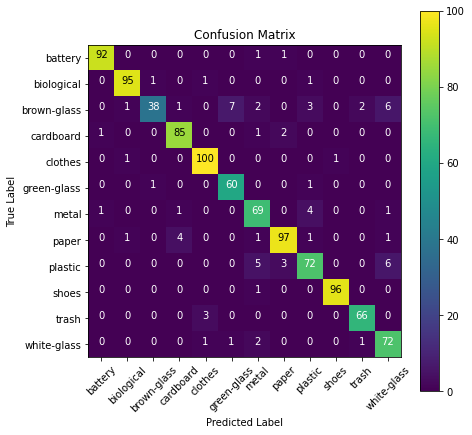

In [ ]:
clf_report(true_value, efficientnetv2s_pred)

1/1 [==============================] - 0s 44ms/step


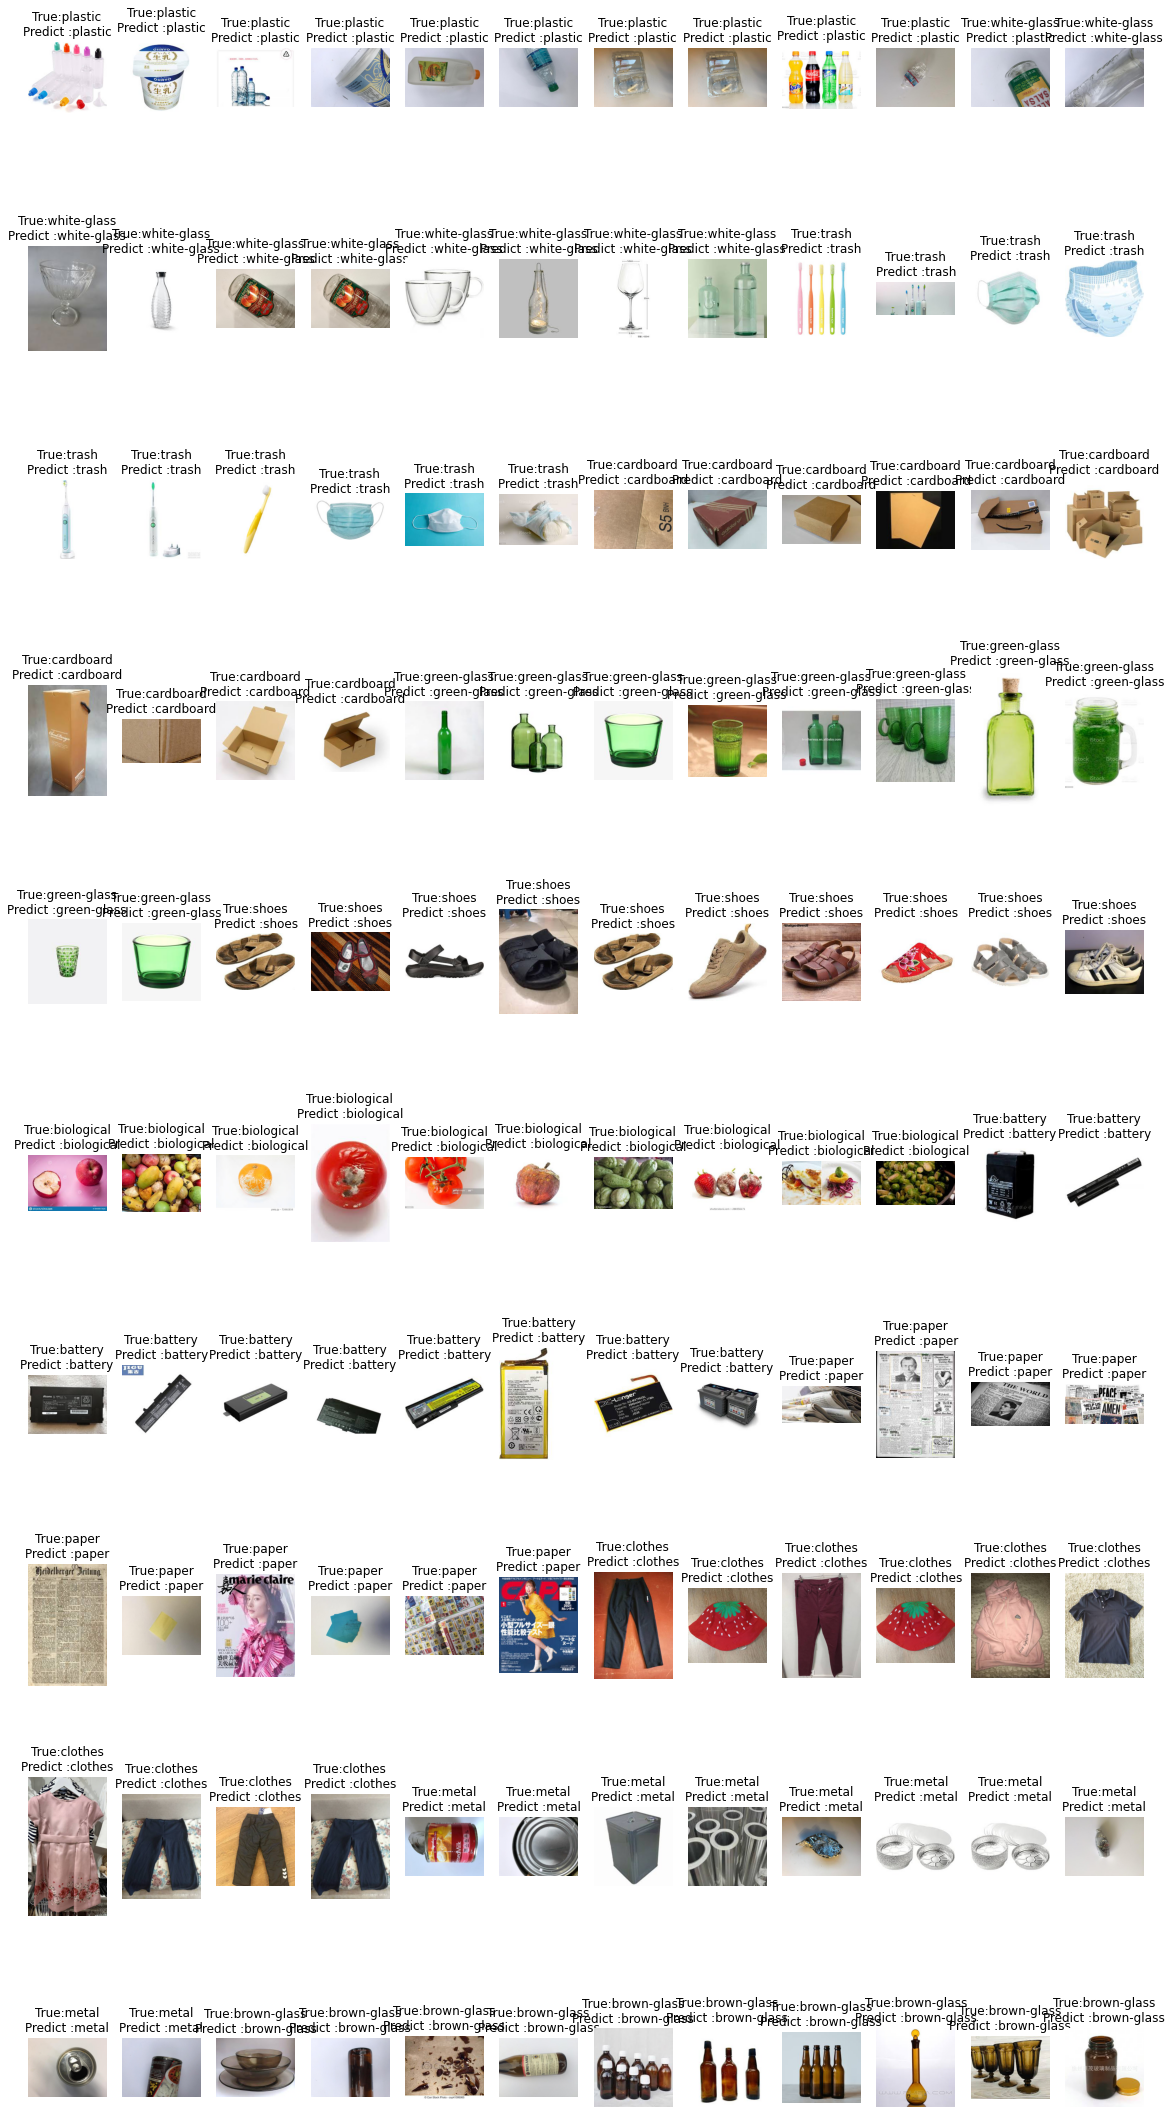

In [ ]:
show_few_images(10, True)

https://www.kaggle.com/code/krishnakumarkk/ensemble-nn-vgg16-resnet50-inceptionv3